In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as la

In [2]:
%matplotlib notebook

In [3]:
def heat_equation(a,b,T,N_x,N_t,u_0,c_a,d_a,h_a,c_b,d_b,h_b):
    """
    Solve the heat equation of the following form using the Crank-Nicolson scheme:
    u_t = u_xx, x ∈ [a, b], t ∈ (0, T]
    u(x, 0) = u_0(x),
    h_a(t) = c_a(t)u(a, t) + d_a(t)u_x(a, t)
    h_b(t) = c_b(t)u(b, t) + d_b(t)u_x(b, t).
    
    Parameters:
    a: float
    b: float, a < b
    T: positive float
    N_x: positive integer, N_x > 2, N_x = numer of mesh nodes in x
    N_t: positive integer, N_t > 1, N_t = number of mesh nodes in t
    u_0: function handle for the initial function auxiliary condition
    c_a: function handle
    d_a: function handle
    h_a: function handle
    c_b: function handle
    d_b: function handle
    h_b: function handle
    
    Returns:
    U: a two dimensional numpy array containing floats.
       Rows correspond to time and columns to x.
    """
    x = np.linspace(a, b, N_x)
    t = np.linspace(0, T, N_t)
    h = x[1] - x[0]
    k = t[1] - t[0]
    lmda = k / (2*h**2)
    
    ha = h_a(t)
    ca = c_a(t)
    da = d_a(t)
    
    hb = h_b(t)
    cb = c_b(t)
    db = d_b(t)
    
    A = sp.diags([lmda, 1-2*lmda, lmda], [-1, 0, 1], shape=(N_x-2, N_x-2))
    B = sp.diags([-lmda, 1+2*lmda, -lmda], [-1, 0, 1], shape=(N_x-2, N_x-2))
    
    U_j = u_0(x)
    U = [U_j]
    for i in range(N_t - 1):
        U_at = U_j[0]
        U_bt = U_j[-1]
        U_ = U_j[1:-1]
        
        coef1_a = ha[i] / (ca[i] - da[i]/h)
        coef2_a = da[i] / (h*ca[i] - da[i])
        coef1_b = hb[i] / (cb[i] + db[i]/h)
        coef2_b = db[i] / (h*cb[i] + db[i])
        
        AU = A@U_
        AU[0] += lmda*U_at + lmda*coef1_a
        AU[-1] += lmda*U_bt + lmda*coef1_b
        
        B_ = B.tocsr().copy()
        B_[0,0] -= lmda*coef2_a
        B_[-1,-1] -= lmda*coef2_b 
        
        U1_ = spsolve(B_, AU)
        Ua = coef1_a - coef2_a * U1_[0]
        Ub = coef1_b - coef2_b * U1_[-1]
        U_j = np.concatenate([[Ua], U1_, [Ub]])
        U.append(U_j)
        
    return np.array(U)

In [4]:
a = 0
b = np.pi
T = 1.0
N_x = 30
N_t = 10
u_0 = lambda x: np.sin(x)
c_a = lambda t:1 + t*0
d_a = lambda t:0*t
h_a = lambda t:0*t
c_b = lambda t:1 + t*0
d_b = lambda t:0*t
h_b = lambda t:0*t
U = heat_equation(a,b,T,N_x,N_t,u_0,c_a,d_a,h_a,c_b,d_b,h_b)

<IPython.core.display.Javascript object>


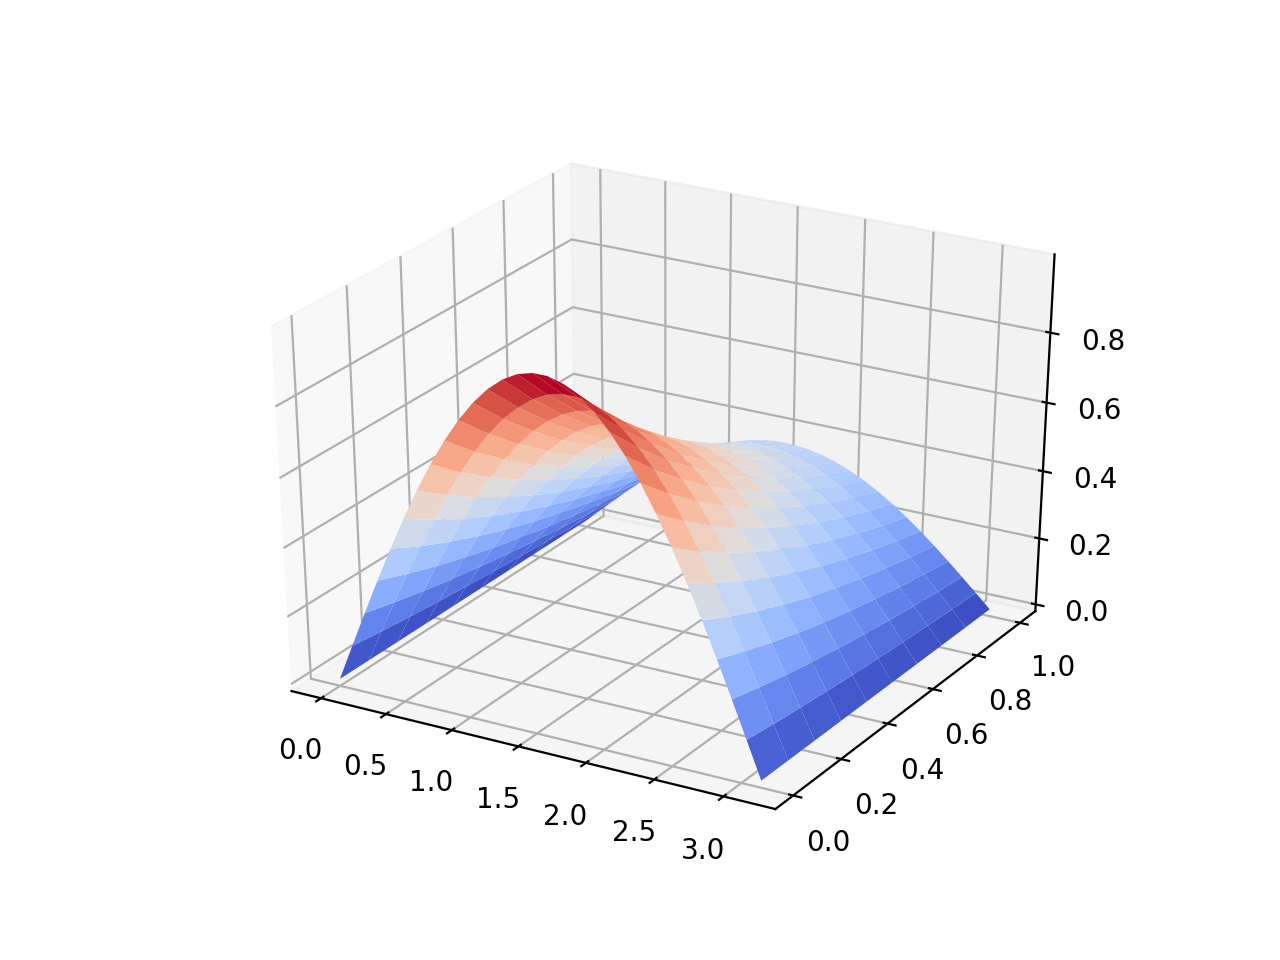

In [5]:
x = np.linspace(a, b, N_x)
t = np.linspace(0, T, N_t)
X,t = np.meshgrid(x, t)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, t, U, cmap="coolwarm")
plt.show()

In [12]:
def heat_equation_test(a,b,T,N_x,N_t,u_0,c_a,d_a,h_a,c_b,d_b,h_b):

    # a - float
    # b - float
    # T - positive float
    # N_x - positive integer
    # N_t - positive integer
    # u_0 - function handle for the initial function auxiliary condition
    # c_a - function handle 
    # d_a - function handle
    # h_a - function handle
    # c_b - function handle 
    # d_b - function handle
    # h_b - function handle
    
    delx = (b-a)/(N_x-1)
    delt = T/(N_t-1)
    
    # this is a specific solution for testin purposes
    U = np.zeros((N_t,N_x))
    
    for j in range(0,N_t):
        t = j*delt
        for k in range(0,N_x):
            x= k*delx
            U[j,k] = np.exp(-t)*np.sin(x)

    return U

In [14]:
a = 0
b = np.pi
T = 1.0
N_x = 30
N_t = 10
u_0 = lambda x: np.sin(x)
c_a = lambda t:1
d_a = lambda t:0
h_a = lambda t:0
c_b = lambda t:1
d_b = lambda t:0
h_b = lambda t:0
U_test = heat_equation_test(a,b,T,N_x,N_t,u_0,c_a,d_a,h_a,c_b,d_b,h_b)

<IPython.core.display.Javascript object>


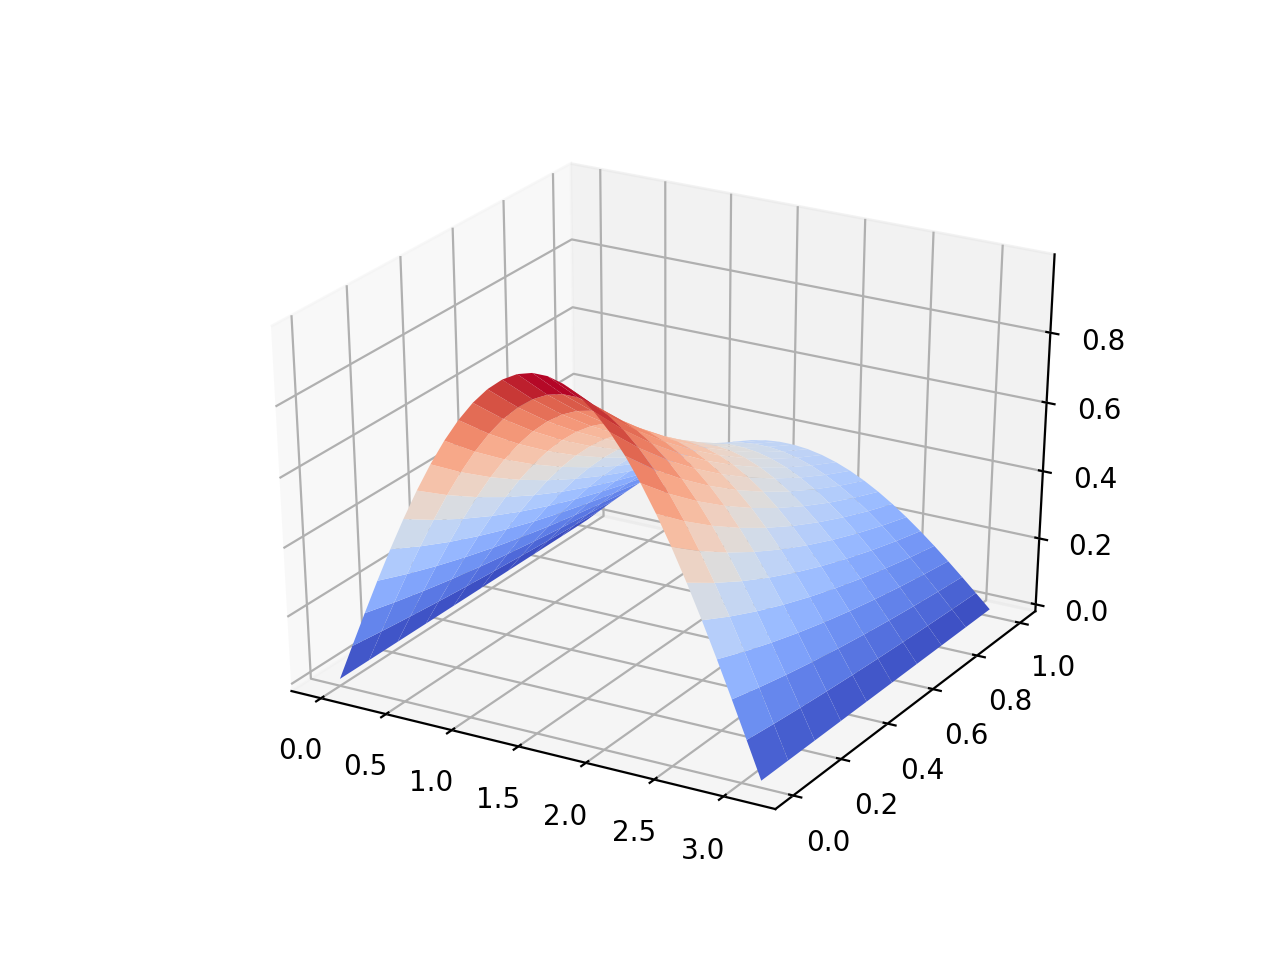

In [15]:
x = np.linspace(a, b, N_x)
t = np.linspace(0, T, N_t)
X,t = np.meshgrid(x, t)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, t, U_test, cmap="coolwarm")
plt.show()

In [116]:
def bfgs(Df, x0, maxiter=100, tol=1e-5):
    """Use BFGS to minimize a function f:R^n -> R.

    Parameters:
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        maxiter (int): The maximum number of iterations to compute.
        tol (float): The stopping tolerance.

    Returns:
        ((n,) ndarray): The approximate optimizer of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    # Keep track of convergence and number of iterations
    converged = False
    iterations = 0
    n = len(x0)
    A_inv = np.eye(n)
    dfx = Df(x0)
    # Loop maxiter number of times before convergence 
    for i in range(maxiter):
        iterations += 1
        # Equation 12.6
        x1 = x0 - A_inv@dfx
        # Condition for convergence
        if la.norm(dfx) < tol:
            converged = True
            break
        # Store all necessary values for efficiency
        s = x1 - x0
        dfx1 = Df(x1)
        y = dfx1 - dfx
        dfx = dfx1
        sy = np.dot(s,y)
        # Avoid dividing by 0
        if sy == 0:
            break
        # Equation 12.7
        A_inv += ((np.dot(s,y) + np.dot(y, A_inv@y))*np.outer(s,s))/(sy**2) \
                 - (A_inv@np.outer(y,s) + np.outer(s,y)@A_inv)/sy
        # Update x0
        x0 = x1

    return x1, converged, iterations

def f(U1, U0, K1, K2, dx, ha_i, ca_i, da_i, hb_i, cb_i, db_i):
    """
    The nonlinear implicit Crank-Nicholson equations for 
    the Burgers' equation.
    
    Parameters
    ----------
        U1 (ndarray): The values of U^(n+1)
        U0 (ndarray): The values of U^n
        s (float): wave speed
        K1 (float): first constant in the equations
        K2 (float): second constant in the equations
    
    Returns
    ----------
        out (ndarray): The residuals (differences between right- and 
                    left-hand sides) of the equation, accounting 
                    for boundary conditions
    """
    coef1_a = ha_i / (ca_i - da_i/dx)
    coef2_a = da_i / (dx*ca_i - da_i)
    coef1_b = hb_i / (cb_i + db_i/dx)
    coef2_b = db_i / (dx*cb_i + db_i)
    
    RHS = U1[1:-1] - U0[1:-1]
    LHS1 = K1*((U1[1:-1] + U0[1:-1]) * \
               (U1[2:] - U1[:-2] + U0[2:] - U0[:-2]))
    LHS2 = K2*(U1[2:] - 2*U1[1:-1] + U1[:-2] + \
               U0[2:] - 2*U0[1:-1] + U0[:-2])
    
    residual = RHS - (LHS1 + LHS2)
    boundary_a = U1[0] - (coef1_a - coef2_a*U1[1])
    boundary_b = U1[-1] - (coef1_b - coef2_b*U1[-2])
    
    out = np.concatenate([[boundary_a], residual, [boundary_b]])
    return out

def burgers_equation(a,b,T,N_x,N_t,u_0,c_a,d_a,h_a,c_b,d_b,h_b):
    """
    Solve the Burgers equation of the following form using the Crank-Nicolson scheme:
    u_t + u*u_x = u_xx, x ∈ [a, b], t ∈ (0, T]
    u(x, 0) = u_0(x),
    h_a(t) = c_a(t)u(a, t) + d_a(t)u_x(a, t)
    h_b(t) = c_b(t)u(b, t) + d_b(t)u_x(b, t).
    
    Parameters:
    a: float
    b: float, a < b
    T: positive float
    N_x: positive integer, N_x > 2, N_x = numer of mesh nodes in x
    N_t: positive integer, N_t > 1, N_t = number of mesh nodes in t
    u_0: function handle for the initial function auxiliary condition
    c_a: function handle
    d_a: function handle
    h_a: function handle
    c_b: function handle
    d_b: function handle
    h_b: function handle
    
    Returns:
    U: a two dimensional numpy array containing floats.
       Rows correspond to time and columns to x.
    """
    x = np.linspace(a, b, N_x)
    t = np.linspace(0, T, N_t)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    
    ha = h_a(t)
    ca = c_a(t)
    da = d_a(t)
    
    hb = h_b(t)
    cb = c_b(t)
    db = d_b(t)
    
    K1 = -dt / (8*dx)
    K2 = dt / (2*dx**2)
    
    U0 = u_0(x)
    U = [U0]
    for i in range(N_t - 1):
        def g(U1):
            return f(U1, U0, K1, K2, dx, ha[i], ca[i], da[i], hb[i], cb[i], db[i])
        
        U1, conv, iterations = bfgs(g, U0)
        U.append(U1)
        U0 = U1
    
    return np.array(U)

In [117]:
a = -20
b = 20
T = 1.0
N_x = 150
N_t = 350
u_hat = lambda x: 3 - 2*np.tanh(2*x/2)
v = lambda x: 3.5*(np.sin(3*x) + 1) * (1/np.sqrt(2*np.pi))*np.exp(-x**2/2)
u_0 = lambda x: u_hat(x) + v(x)
c_a = lambda t:1 + t*0
d_a = lambda t:0*t
h_a = lambda t:5 + 0*t
c_b = lambda t:1 + t*0
d_b = lambda t:0*t
h_b = lambda t:1 + 0*t
U_burgers = burgers_equation(a,b,T,N_x,N_t,u_0,c_a,d_a,h_a,c_b,d_b,h_b)

<IPython.core.display.Javascript object>


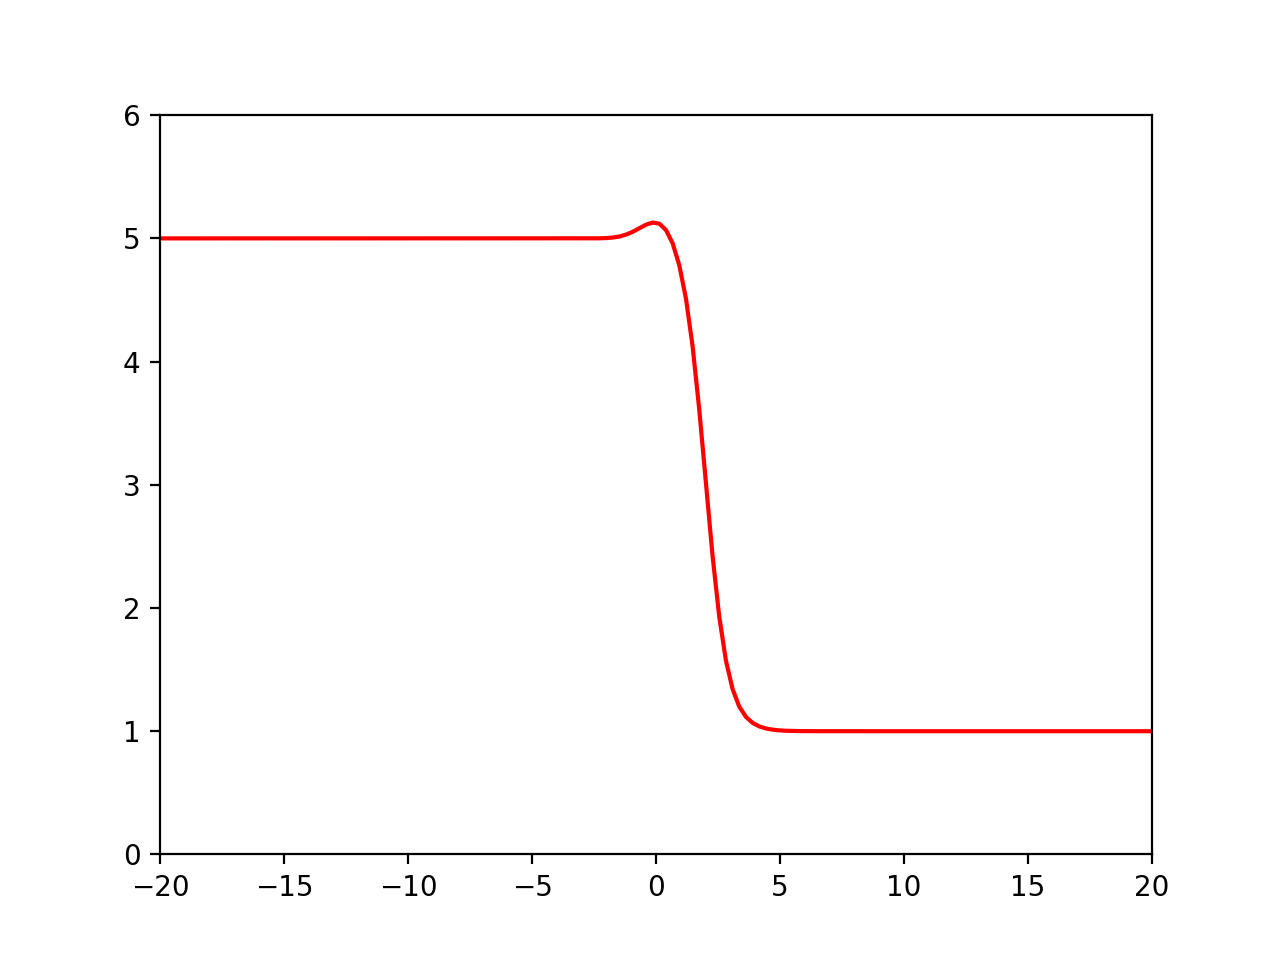

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((a, b))
ax.set_ylim((0, 6))
traj, = plt.plot([],[], color='r')
particle, = plt.plot([],[], marker='o', color='r')
def update(i):
    traj.set_data(x, U_burgers[i])
    return particle, traj

ani = animation.FuncAnimation(fig, update, frames=range(N_t), interval=10)
plt.show()

In [97]:
from scipy.optimize import fsolve
from scipy.optimize import root

def f(TS1, TS0, K1, K2, K3, K4, B, C1, dx, N_X,
      hTa_i, cTa_i, dTa_i, hTb_i, cTb_i, dTb_i, 
      hSa_i, cSa_i, dSa_i, hSb_i, cSb_i, dSb_i):
    """
    The nonlinear implicit Crank-Nicholson equations for 
    the Wildfire model.
    
    Parameters
    ----------
        U1 (ndarray): The values of U^(n+1)
        U0 (ndarray): The values of U^n
        s (float): wave speed
        K1 (float): first constant in the equations
        K2 (float): second constant in the equations
    
    Returns
    ----------
        out (ndarray): The residuals (differences between right- and 
                    left-hand sides) of the equation, accounting 
                    for boundary conditions
    """
    coef_T1_a = hTa_i / (cTa_i - dTa_i/dx)
    coef_T2_a = dTa_i / (dx*cTa_i - dTa_i)
    coef_T1_b = hTb_i / (cTb_i + dTb_i/dx)
    coef_T2_b = dTb_i / (dx*cTb_i + dTb_i)
    
    coef_S1_a = hSa_i / (cSa_i - dSa_i/dx)
    coef_S2_a = dSa_i / (dx*cSa_i - dSa_i)
    coef_S1_b = hSb_i / (cSb_i + dSb_i/dx)
    coef_S2_b = dSb_i / (dx*cSb_i + dSb_i)
    
    T0 = TS0[:N_x]
    S0 = TS0[N_x:]
    T1 = TS1[:N_x]
    S1 = TS1[N_x:]

    RHS_T = T1[1:-1] - T0[1:-1]
    LHS1_T = K1*(T1[:-2] - 2*T1[1:-1] + T1[2:] +
                 T0[:-2] - 2*T0[1:-1] + T0[2:])
    LHS2_T = K2*(T1[2:] - T1[:-2] + T0[2:] - T0[:-2])
    LHS3_T = K3*((S1[1:-1] + S0[1:-1]) * 
                np.exp(-2*B / (T1[1:-1] + T0[1:-1]))
                - C1*(T1[1:-1] + T0[1:-1]))
    residual_T = RHS_T - (LHS1_T + LHS2_T + LHS3_T)
    
    RHS_S = S1[1:-1] - S0[1:-1]
    LHS_S = K4*(S1[1:-1] + S0[1:-1]) * \
               np.exp(-2*B / (T1[1:-1] + T0[1:-1]))
    residual_S = RHS_S - LHS_S
    
    boundary_T_a = T1[0] - (coef_T1_a - coef_T2_a*T1[1])
    boundary_T_b = T1[-1] - (coef_T1_b - coef_T2_b*T1[-2])
    boundary_S_a = S1[0] - (coef_S1_a - coef_S2_a*S1[1])
    boundary_S_b = S1[-1] - (coef_S1_b - coef_S2_b*S1[-2])
    
    T_out = np.concatenate([[boundary_T_a], residual_T, [boundary_T_b]])
    S_out = np.concatenate([[boundary_S_a], residual_S, [boundary_S_b]])
    return np.concatenate([T_out, S_out])

def wildfire_model(a,b,T,N_x,N_t,T_0,S_0,cT_a,dT_a,hT_a,cT_b,dT_b,hT_b,
                   cS_a,dS_a,hS_a,cS_b,dS_b,hS_b,A,B,C1,C2,nu):
    """
    Solve the Wildfire model of the following form using the Crank-Nicolson scheme:
    T_t = T_xx - ν*T_x + A*(S*exp(−B/T) − C1*T),
    S_t = -C2*S*exp(-B/T), x ∈ [a, b], t ∈ (0, T]
    T(x, 0) = T_0(x),
    S(x, 0) = S_0(x),
    hT_a(t) = cT_a(t)T(a, t) + dT_a(t)T_x(a, t),
    hT_b(t) = cT_b(t)T(b, t) + dT_b(t)T_x(b, t),
    hS_a(t) = cS_a(t)S(a, t) + dS_a(t)S_x(a, t),
    hS_b(t) = cS_b(t)S(b, t) + dS_b(t)S_x(b, t).
    
    Parameters:
    a: float
    b: float, a < b
    T: positive float
    N_x: positive integer, N_x > 2, N_x = number of mesh nodes in x
    N_t: positive integer, N_t > 1, N_t = number of mesh nodes in t
    T_0: function handle for the initial function auxiliary condition for T
    S_0: function handle for the initial function auxiliary condition for S
    cT_a: function handle
    dT_a: function handle
    hT_a: function handle
    cT_b: function handle
    dT_b: function handle
    hT_b: function handle
    cS_a: function handle
    dS_a: function handle
    hS_a: function handle
    cS_b: function handle
    dS_b: function handle
    hS_b: function handle
    A: float
    B: float
    C1: float
    C2: float
    nu: float (ν)
    
    Returns
    T: a two dimensional numpy array containing floats.
       Rows correspond to time and columns to x for T.
    S: a two dimensional numpy array containing floats.
       Rows correspond to time and columns to x for S.
    
    """
    x, dx = np.linspace(a, b, N_x, retstep=True)
    t, dt = np.linspace(0, T, N_t, retstep=True)
    
    hTa = hT_a(t)
    cTa = cT_a(t)
    dTa = dT_a(t)
    hTb = hT_b(t)
    cTb = cT_b(t)
    dTb = dT_b(t)
    
    hSa = hS_a(t)
    cSa = cS_a(t)
    dSa = dS_a(t)
    hSb = hS_b(t)
    cSb = cS_b(t)
    dSb = dS_b(t)
    
    K1 = dt / (2*dx**2)
    K2 = -nu*dt / (2*dx)
    K3 = A*dt/2
    K4 = -C2*dt/2
    
    T0 = T_0(x)
    T = [T0]
    S0 = S_0(x)
    S = [S0]
    for i in range(N_t - 1):
        def g(TS1):
            return f(TS1, TS0, K1, K2, K3, K4, B, C1, dx, N_x,
                     hTa[i], cTa[i], dTa[i], hTb[i], cTb[i], dTb[i], 
                     hSa[i], cSa[i], dSa[i], hSb[i], cSb[i], dSb[i])
        
        TS0 = np.concatenate([T0, S0])
        TS1 = fsolve(g, TS0)
        T0 = TS1[:N_x]
        S0 = TS1[N_x:]
        T.append(T0)
        S.append(S0)
        
    return np.array(T), np.array(S)

In [92]:
a = 0
b = np.pi
T = 1.0
N_x = 30
N_t = 10
A = 1
B = 0
C1 = 1
C2 = 0
nu = 1
T_0 = lambda x: np.sin(x)
S_0 = lambda x: np.sin(x)
cT_a = lambda t:1 + t*0
dT_a = lambda t:0*t
hT_a = lambda t:0*t
cT_b = lambda t:1 + t*0
dT_b = lambda t:0*t
hT_b = lambda t:0*t
cS_a = lambda t:1 + t*0
dS_a = lambda t:0*t
hS_a = lambda t:0*t
cS_b = lambda t:1 + t*0
dS_b = lambda t:0*t
hS_b = lambda t:0*t
T, S = wildfire_model(a,b,T,N_x,N_t,T_0,S_0,cT_a,dT_a,hT_a,cT_b,dT_b,hT_b,
                      cS_a,dS_a,hS_a,cS_b,dS_b,hS_b,A,B,C1,C2,nu)

<IPython.core.display.Javascript object>


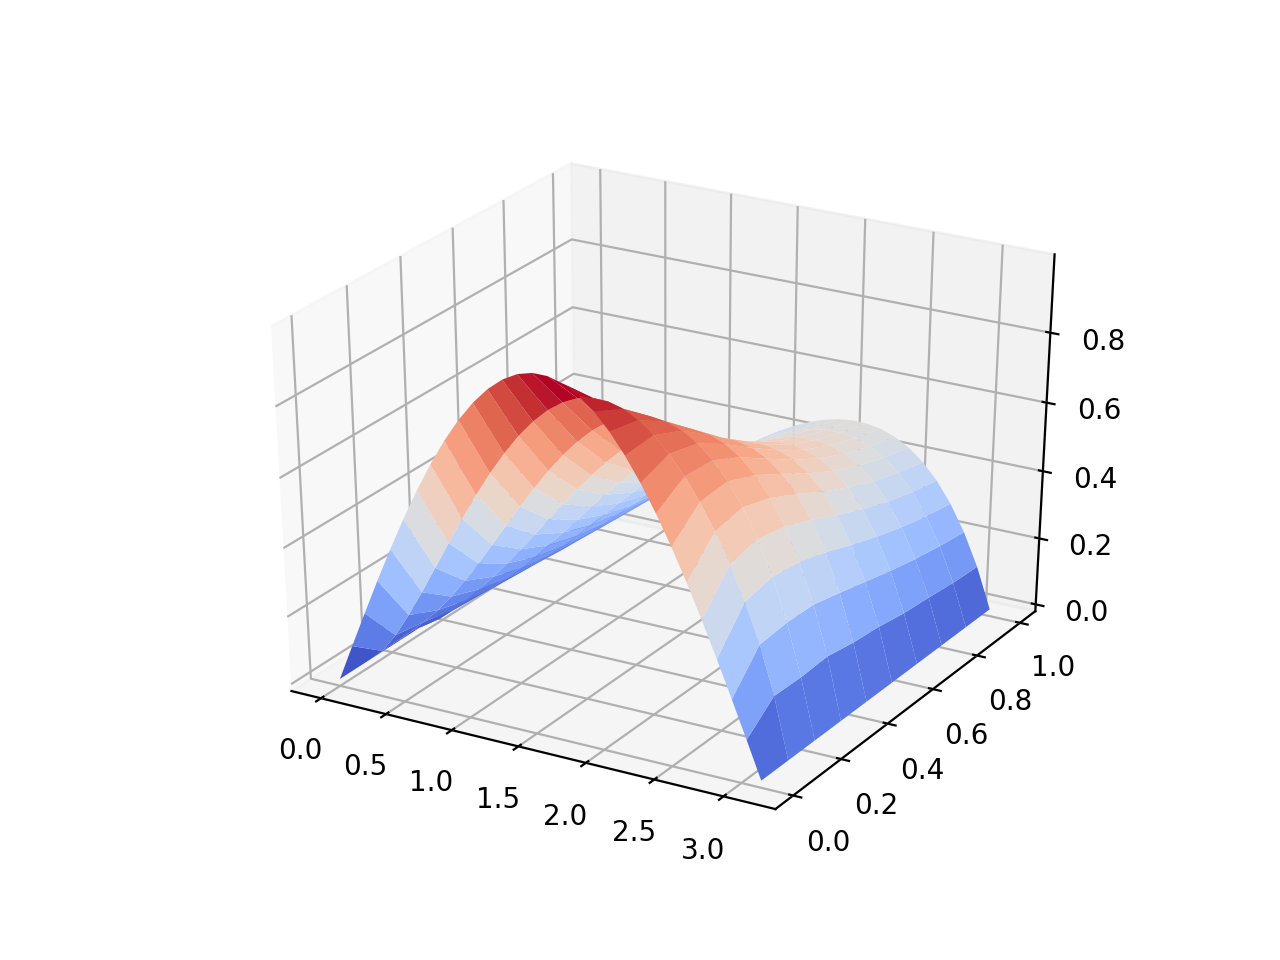

In [93]:
x = np.linspace(a, b, N_x)
t = np.linspace(0, 1, N_t)
X,t = np.meshgrid(x, t)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, t, T, cmap="coolwarm")
plt.show()

<IPython.core.display.Javascript object>


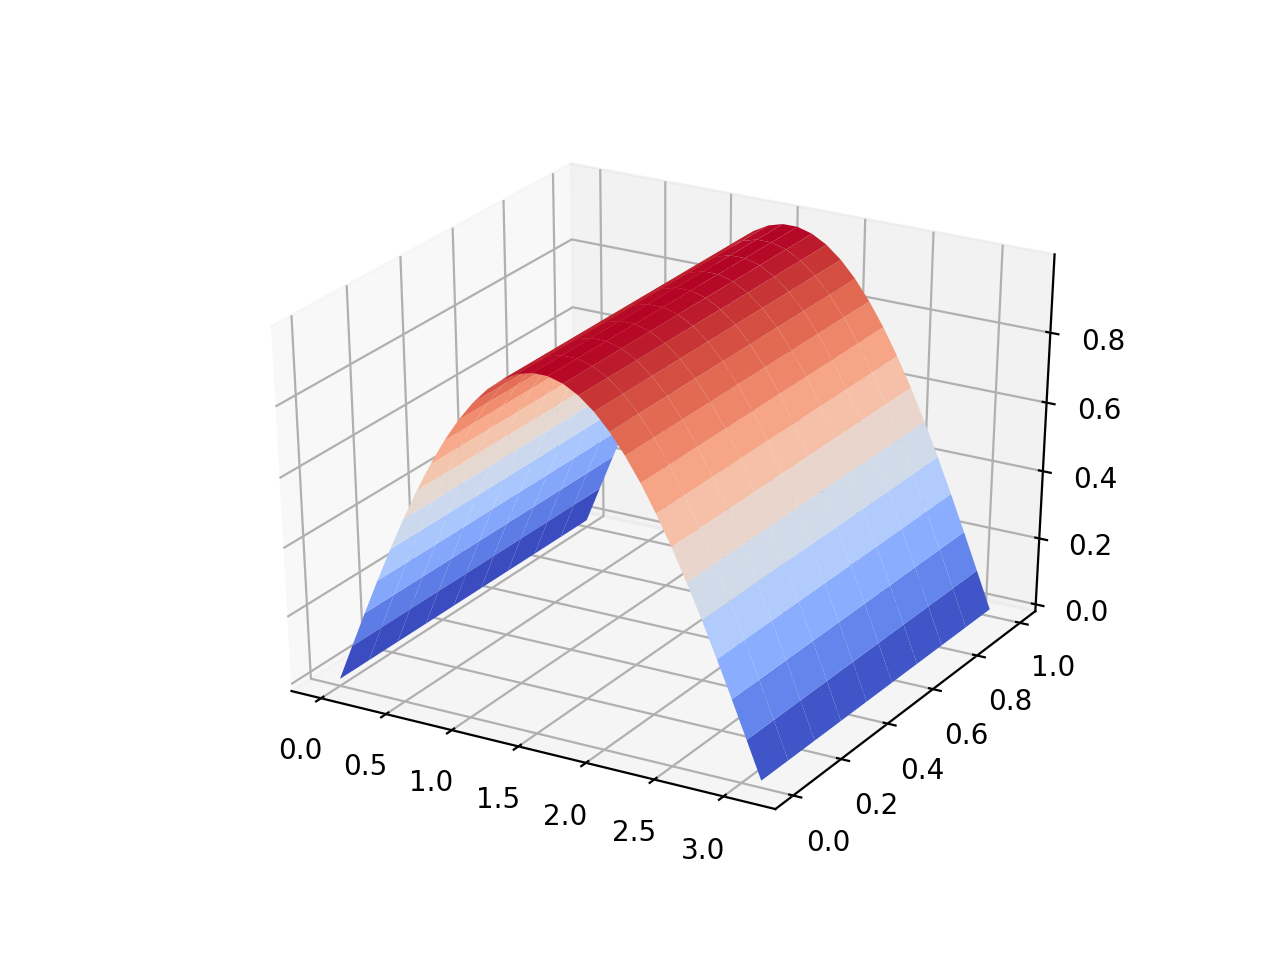

In [86]:
x = np.linspace(a, b, N_x)
t = np.linspace(0, 1, N_t)
X,t = np.meshgrid(x, t)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, t, S, cmap="coolwarm")
plt.show()

In [98]:
# Test1
a = 0
b = 10
T = 20
N_x = 100
N_t = 400
x = np.linspace(a, b, N_x)

#have most of the heat be at the origin.
T_0 = lambda x : 4* np.exp(-x**2)

#Distribute fuel uniformly.
S_0 = lambda x : np.full_like(x, 4)

#Insulate T at the ends.
hT_a = hT_b = lambda x : np.zeros_like(x)
cT_a = cT_b = lambda x : np.zeros_like(x)
dT_a = dT_b = lambda x : np.ones_like(x)

#Put no fuel at the ends.
hS_a = hS_b = lambda x : np.zeros_like(x)
cS_a = cS_b = lambda x : np.ones_like(x)
dS_a = dS_b = lambda x : np.zeros_like(x)

#No idea what to set the constants to, so I'm just going to set them all to 1.
A = B = C1 = C2 = nu = 1

#Have the wildfire model solve it.
print("Calling wildfire model")
T, S = wildfire_model(a,b,T,N_x,N_t,T_0,S_0,cT_a,dT_a,hT_a,cT_b,
                        dT_b,hT_b,cS_a,dS_a,hS_a,cS_b,dS_b,hS_b,A,B,C1,C2,nu)
print("Back from wildfire model")

Calling wildfire model
Back from wildfire model


<IPython.core.display.Javascript object>


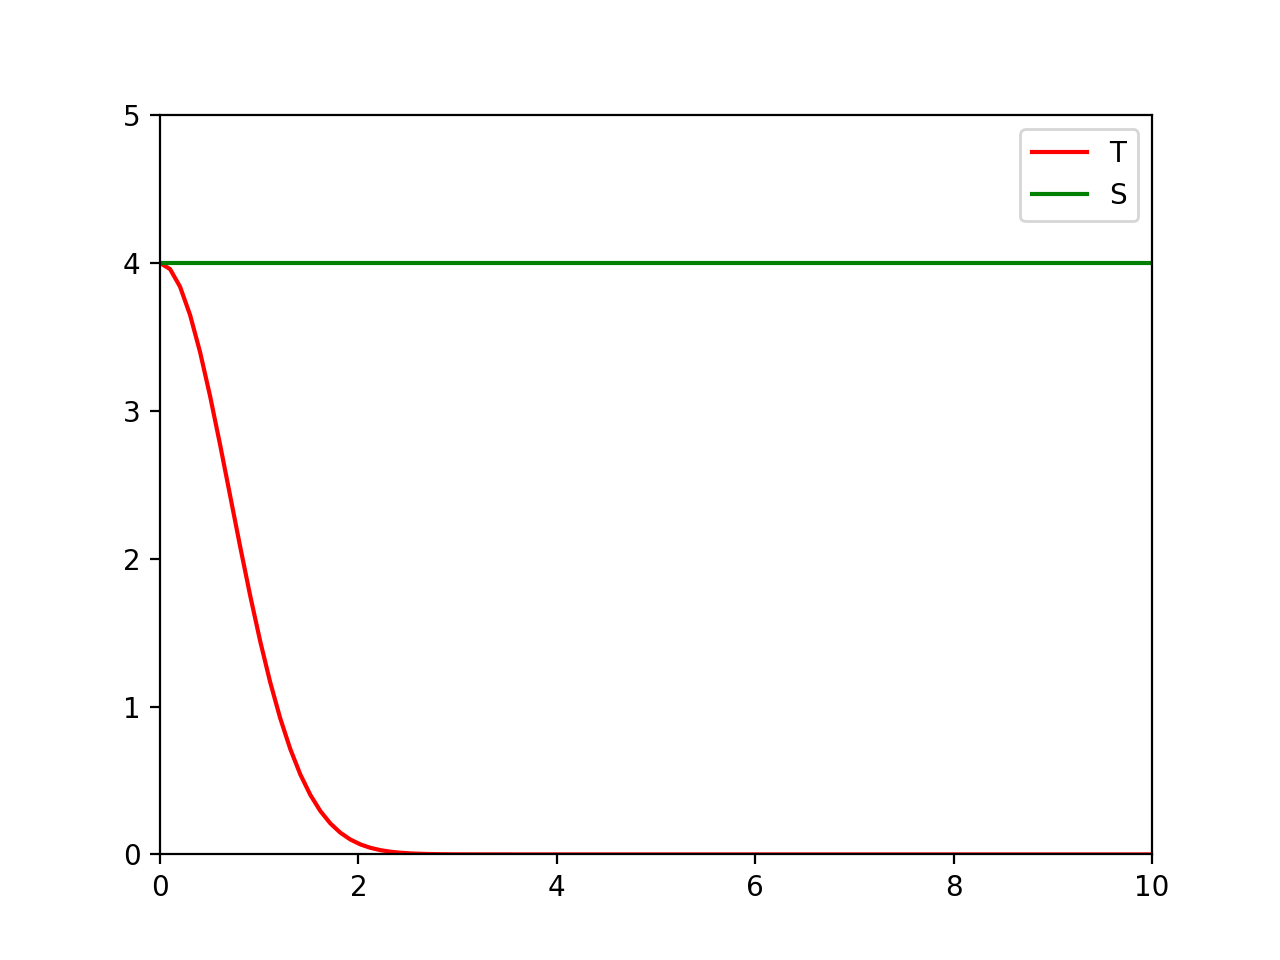

Constructing animation
Animation saved


In [95]:
#Animate the solution
#Make figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((0, 10))
ax.set_ylim((0, 5))

#Line objects.
temp_line, = ax.plot([],[],'r',label='T')
fuel_line, = ax.plot([],[],'g',label='S')

#update func.
def update(i):
    temp_line.set_data(x, T[i, :])
    fuel_line.set_data(x, S[i, :])
    return temp_line, fuel_line

#Animation object.
print("Constructing animation")
plt.legend()
ani = animation.FuncAnimation(fig, update, frames=N_t,interval=25)

ani.save("wildfire.mp4")

print("Animation saved")


Calling wildfire model


/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in true_divide


Back from wildfire model


<IPython.core.display.Javascript object>


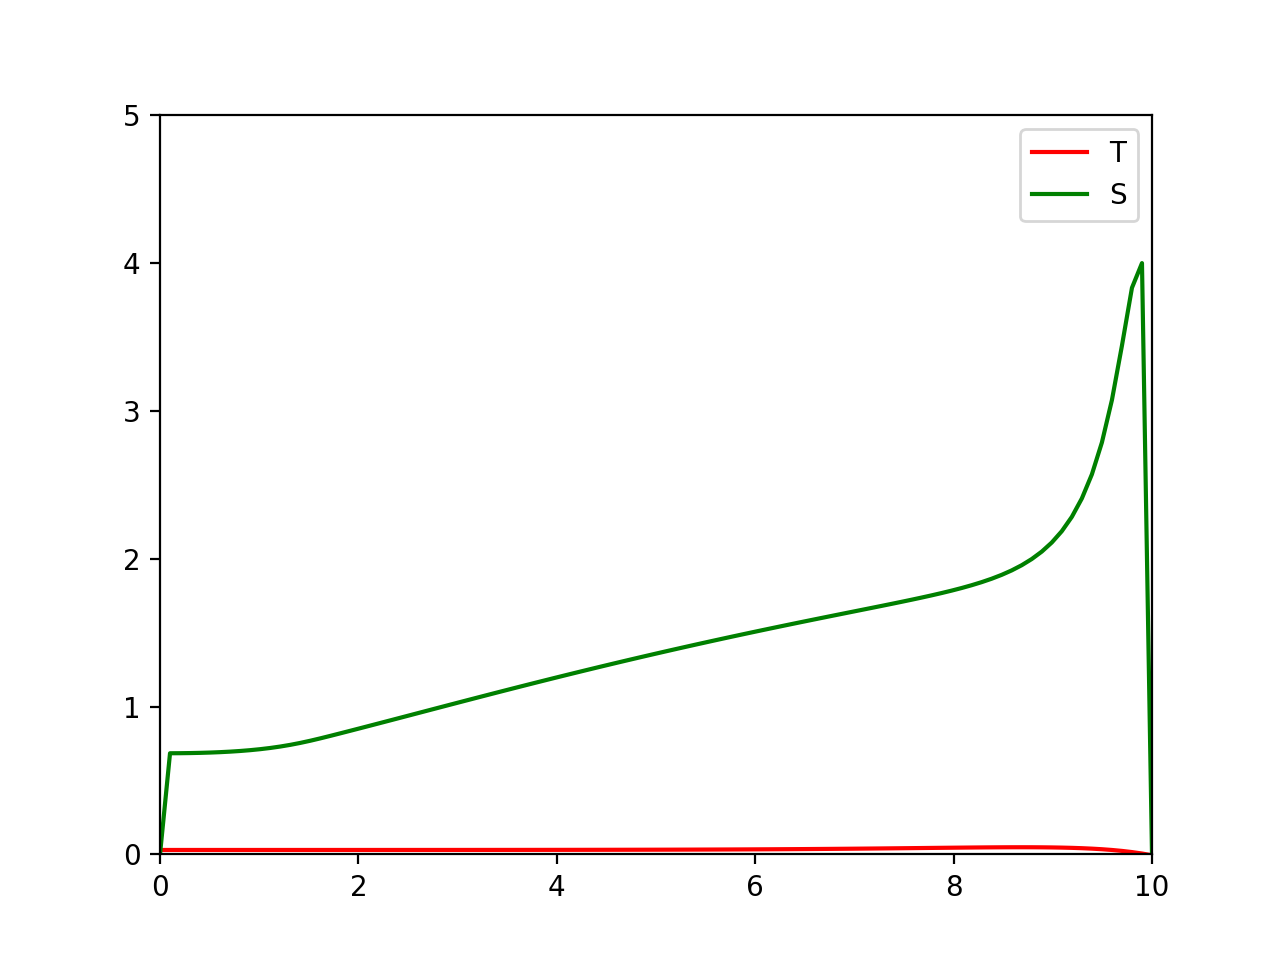

Constructing animation
Animation saved


In [96]:
# test2

a = 0
b = 10
T = 20
N_x = 100
N_t = 400
x = np.linspace(a, b, N_x)

#have most of the heat be at the origin.
T_0 = lambda x : 6 * np.exp(-10*(x-1)**2)

#Distribute fuel uniformly.
S_0 = lambda x : 4 * (x/10)**(1/9) * (1 - x/10)**(1/9)

#Insulate T at the ends.
hT_a = hT_b = lambda x : np.zeros_like(x)
cT_a = cT_b = lambda x : np.zeros_like(x)
dT_a = dT_b = lambda x : np.ones_like(x)

#Put no fuel at the ends.
hS_a = hS_b = lambda x : np.zeros_like(x)
cS_a = cS_b = lambda x : np.ones_like(x)
dS_a = dS_b = lambda x : np.zeros_like(x)

#No idea what to set the constants to, so I'm just going to set them all to 1.
A = B = C1 = C2 = nu = 1

#Have the wildfire model solve it.
print("Calling wildfire model")
T, S = wildfire_model(a,b,T,N_x,N_t,T_0,S_0,cT_a,dT_a,hT_a,cT_b,
                        dT_b,hT_b,cS_a,dS_a,hS_a,cS_b,dS_b,hS_b,A,B,C1,C2,nu)
print("Back from wildfire model")
                        
#Animate the solution
#Make figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((0, 10))
ax.set_ylim((0, 5))

#Line objects.
temp_line, = ax.plot([],[],'r',label='T')
fuel_line, = ax.plot([],[],'g',label='S')

#update func.
def update(i):
    temp_line.set_data(x, T[i, :])
    fuel_line.set_data(x, S[i, :])
    return temp_line, fuel_line

#Animation object.
print("Constructing animation")
plt.legend()
ani = animation.FuncAnimation(fig, update, frames=N_t,interval=25)

ani.save("wildfire2.mp4")

print("Animation saved")
